# COVID-19 in Mexico



## Define the problem
COVID-19 is taking a big toll on the Mexican population. Currently having the 6th place worldwide. I decided to dive in and understand better the current situation in there.

The main question is: 
* Which factor has the biggest impact on deaths once infected with COVID-19?

Other questions to tackle are:
* Is there a correlation between cases and death with days of the week?
* Does the probability of death is increased by the number of days between first symptoms and hospitalization?

In [1]:
__author__ = "Erika Garces"
__email__ = "epgarces3@gmail.com"

In [2]:
# impory libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from os import listdir
import datetime as dt
from datetime import date

from sklearn import preprocessing
from sklearn.metrics import  jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn import linear_model
import statsmodels.api as sm
from sklearn.feature_selection import RFE 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

import itertools
from tabulate import tabulate
from IPython.display import HTML

from fbprophet import Prophet
from fbprophet.plot import plot_plotly

from fbprophet.plot import plot_plotly
import plotly.offline as py
import plotly.express as px

sns.set()
%matplotlib inline

## About datasets

COVID-19 data was taken from Ministry of Health MX:  https://www.gob.mx/salud/documentos/datos-abiertos-152127

## Load the Data 

In [3]:
# Function to print all the files in a folder 
def file_folder (path):
    filepaths = [path + f for f in listdir(path)]
    print (filepaths)

In [4]:
path = "Data/"
covid_general = file_folder(path)

['Data/datos_abiertos_20200810.csv', 'Data/datos_abiertos_20200811.csv', 'Data/gender.csv', 'Data/.DS_Store', 'Data/Mexico-2020.csv', 'Data/mexstates.dbf', 'Data/Catalogos_0412.xlsx', 'Data/mexstates.shp', 'Data/mexstates.shx', 'Data/mexstates.sbx', 'Data/Poblacion_Edad.xlsx', 'Data/.keep', 'Data/200802COVID19MEXICO.csv', 'Data/clean_data.csv', 'Data/01_poblacion.xls', 'Data/.ipynb_checkpoints', 'Data/mexstates.prj', 'Data/mexstates.sbn', 'Data/mexstates.shp.xml', 'Data/Poblacion_Entidad.xlsx', 'Data/Descriptores_0419.xlsx']


In [5]:
# Loading covid-19 file 
df_genera_mx = pd.read_csv(path +"datos_abiertos_20200811.csv", encoding='latin-1')
df_general = df_genera_mx

In [6]:
df_descriptors = pd.read_excel(open(path + 'Descriptores_0419.xlsx', 'rb')) 
df_states = pd.read_excel(open(path + 'Catalogos_0412.xlsx', 'rb'), sheet_name='Catálogo de ENTIDADES') 
df_sector = pd.read_excel(open(path + 'Catalogos_0412.xlsx', 'rb'), sheet_name='Catálogo SECTOR') 
df_paciente = pd.read_excel(open(path + 'Catalogos_0412.xlsx', 'rb'), sheet_name='Catálogo TIPO_PACIENTE') 
df_gender = pd.read_excel(open(path + 'Catalogos_0412.xlsx', 'rb'), sheet_name='Catálogo SEXO') 

## Pre-processing data

In [7]:
# checking the size of the file 
df_general.shape 

(1112114, 35)

In [8]:
df_general['SEXO']= df_general['SEXO'].replace([1, 2], [1, 0])

In [9]:
df_general['TIPO_PACIENTE'] = df_general['TIPO_PACIENTE'].map(df_paciente.set_index('CLAVE')['DESCRIPCIÓN'])

In [10]:
# It replace values for several columns in a dataframe.
def replace_values(df, columns, 
                   old_values, new_values):
    for col in columns:
        try:
            df[col]= df[col].replace(to_replace=old_values, value=new_values)
        except:
            print(col)
    return df 

In [11]:
df_general = df_general.drop(['ENTIDAD_NAC', 'ENTIDAD_RES', 'NACIONALIDAD', 
                              'PAIS_NACIONALIDAD', 'HABLA_LENGUA_INDIG', 'MIGRANTE'], axis=1)

In [12]:
df_general['FECHA_DEF'] = df_general['FECHA_DEF'].replace('9999-99-99', 0)

In [13]:
df_general['DEF'] = df_general.FECHA_DEF.apply(lambda x: 1 if x!=0 else 0)

In [14]:
#the columns were formatted to datetime.
df_general['FECHA_INGRESO'] = pd.to_datetime(df_general['FECHA_INGRESO'].str.strip(), format='%Y/%m/%d')
df_general['FECHA_SINTOMAS'] = pd.to_datetime(df_general['FECHA_SINTOMAS'].str.strip(), format='%Y/%m/%d')
df_general['FECHA_DEF'] = pd.to_datetime(df_general['FECHA_DEF'].str.strip(), format='%Y/%m/%d', errors='ignore')

In [15]:
def cal_time_days(df, column_a, column_b, new_name):
    df[new_name] = df[column_a] -  df[column_b]
    df[new_name] = df[new_name].dt.days.astype("Int32")
    df[new_name] = df[new_name].fillna(0)
    return df

In [16]:
cal_time_days(df_general,'FECHA_DEF', 'FECHA_SINTOMAS', 'DIAS_SINT_DEF')
cal_time_days(df_general,'FECHA_DEF', 'FECHA_INGRESO', 'DIAS_ING_DEF')
cal_time_days(df_general,'FECHA_INGRESO', 'FECHA_SINTOMAS', 'DIAS_SINT_ING')

FECHA_ACTUALIZACION ID_REGISTRO  ORIGEN  SECTOR  ENTIDAD_UM  SEXO  \
0                2020-08-11      1a62a3       2       3          15     1   
1                2020-08-11      1491cc       2       3          27     1   
2                2020-08-11      12bed1       2       3          15     1   
3                2020-08-11      117245       2       3          25     0   
4                2020-08-11      117cf6       2       3          27     1   
...                     ...         ...     ...     ...         ...   ...   
1112109          2020-08-11      1a5933       2      12           9     0   
1112110          2020-08-11      10a806       1      12          24     0   
1112111          2020-08-11      0827ce       2       6          28     1   
1112112          2020-08-11      0f5bb8       1       4          11     1   
1112113          2020-08-11      032f33       2      12          28     0   

         MUNICIPIO_RES  TIPO_PACIENTE FECHA_INGRESO FECHA_SINTOMAS  ...  \
0                    2    AMBULATORIO    2020-06-11     2020-06-08  ...   
1                    4    AMBULATORIO    2020-06-25     2020-06-23  ...   
2                  106    AMBULATORIO    2020-06-27     2020-06-24  ...   
3                    6    AMBULATORIO    2020-05-06     2020-04-27  ...   
4                   13  HOSPITALIZADO    2020-05-08     2020-05-01  ...   
...                ...            ...           ...            ...  ...   
1112109             14    AMBULATORIO    2020-08-08     2020-08-05  ...   
1112110             20  HOSPITALIZADO    2020-08-07     2020-08-02  ...   
1112111             21    AMBULATORIO    2020-08-08     2020-08-01  ...   
1112112             27    AMBULATORIO    2020-08-09     2020-08-04  ...   
1112113              3    AMBULATORIO    2020-08-04     2020-07-28  ...   

        RENAL_CRONICA  TABAQUISMO  OTRO_CASO  RESULTADO  PAIS_ORIGEN  UCI  \
0                   2           2          1          1           99   97   
1                   2           2          1          1           99   97   
2                   2           2         99          1           99   97   
3                   2           2         99          1           99   97   
4                   2           2          2          1           99    2   
...               ...         ...        ...        ...          ...  ...   
1112109             2           2          2          3           99   97   
1112110             2           2          2          3           99    2   
1112111             2           2          2          3           99   97   
1112112             2           2         99          3           99   97   
1112113             2           2          1          3           99   97   

         DEF  DIAS_SINT_DEF  DIAS_ING_DEF  DIAS_SINT_ING  
0          0              0             0              3  
1          0              0             0              2  
2          0              0             0              3  
3          0              0             0              9  
4          0              0             0              7  
...      ...            ...           ...            ...  
1112109    0              0             0              3  
1112110    0              0             0              5  
1112111    0              0             0              7  
1112112    0              0             0              5  
1112113    0              0             0              7  

[1112114 rows x 33 columns]

In [17]:
df_general['FECHA_INGRESO_SEMANAL'] = df_general['FECHA_INGRESO'].dt.dayofweek
df_general['WEEKEND'] = df_general['FECHA_INGRESO_SEMANAL'].apply(lambda x: 1 if (x>4) else 0)

In [18]:
#Selecting the columns that have a format of SI and NO.
df_descriptors['FORMATO O FUENTE'] = df_descriptors['FORMATO O FUENTE'].str.strip()
df_si_no_answer = df_descriptors[df_descriptors['FORMATO O FUENTE']== 'CATÁLOGO: SI_ NO']
column_list_binary = list(df_si_no_answer['NOMBRE DE VARIABLE'].values)
column_list_binary.append('RESULTADO')
column_list_binary.append('OTRO_CASO')
column_list_binary.append('OTRA_COM')

In [19]:
#The values for the columns with SI NO format are replace with 1 and 0.
df_general =replace_values(df_general, column_list_binary, [97, 98, 99], [2,2,2])
df_general =replace_values(df_general, column_list_binary, [1,2], [1,0])


HABLA_LENGUA_INDIG
OTRAS_COM
MIGRANTE
HABLA_LENGUA_INDIG
OTRAS_COM
MIGRANTE


In [20]:
df_positive = df_general[ df_general['RESULTADO'] == 1]
df_positive = df_positive.drop(['RESULTADO'], axis=1)

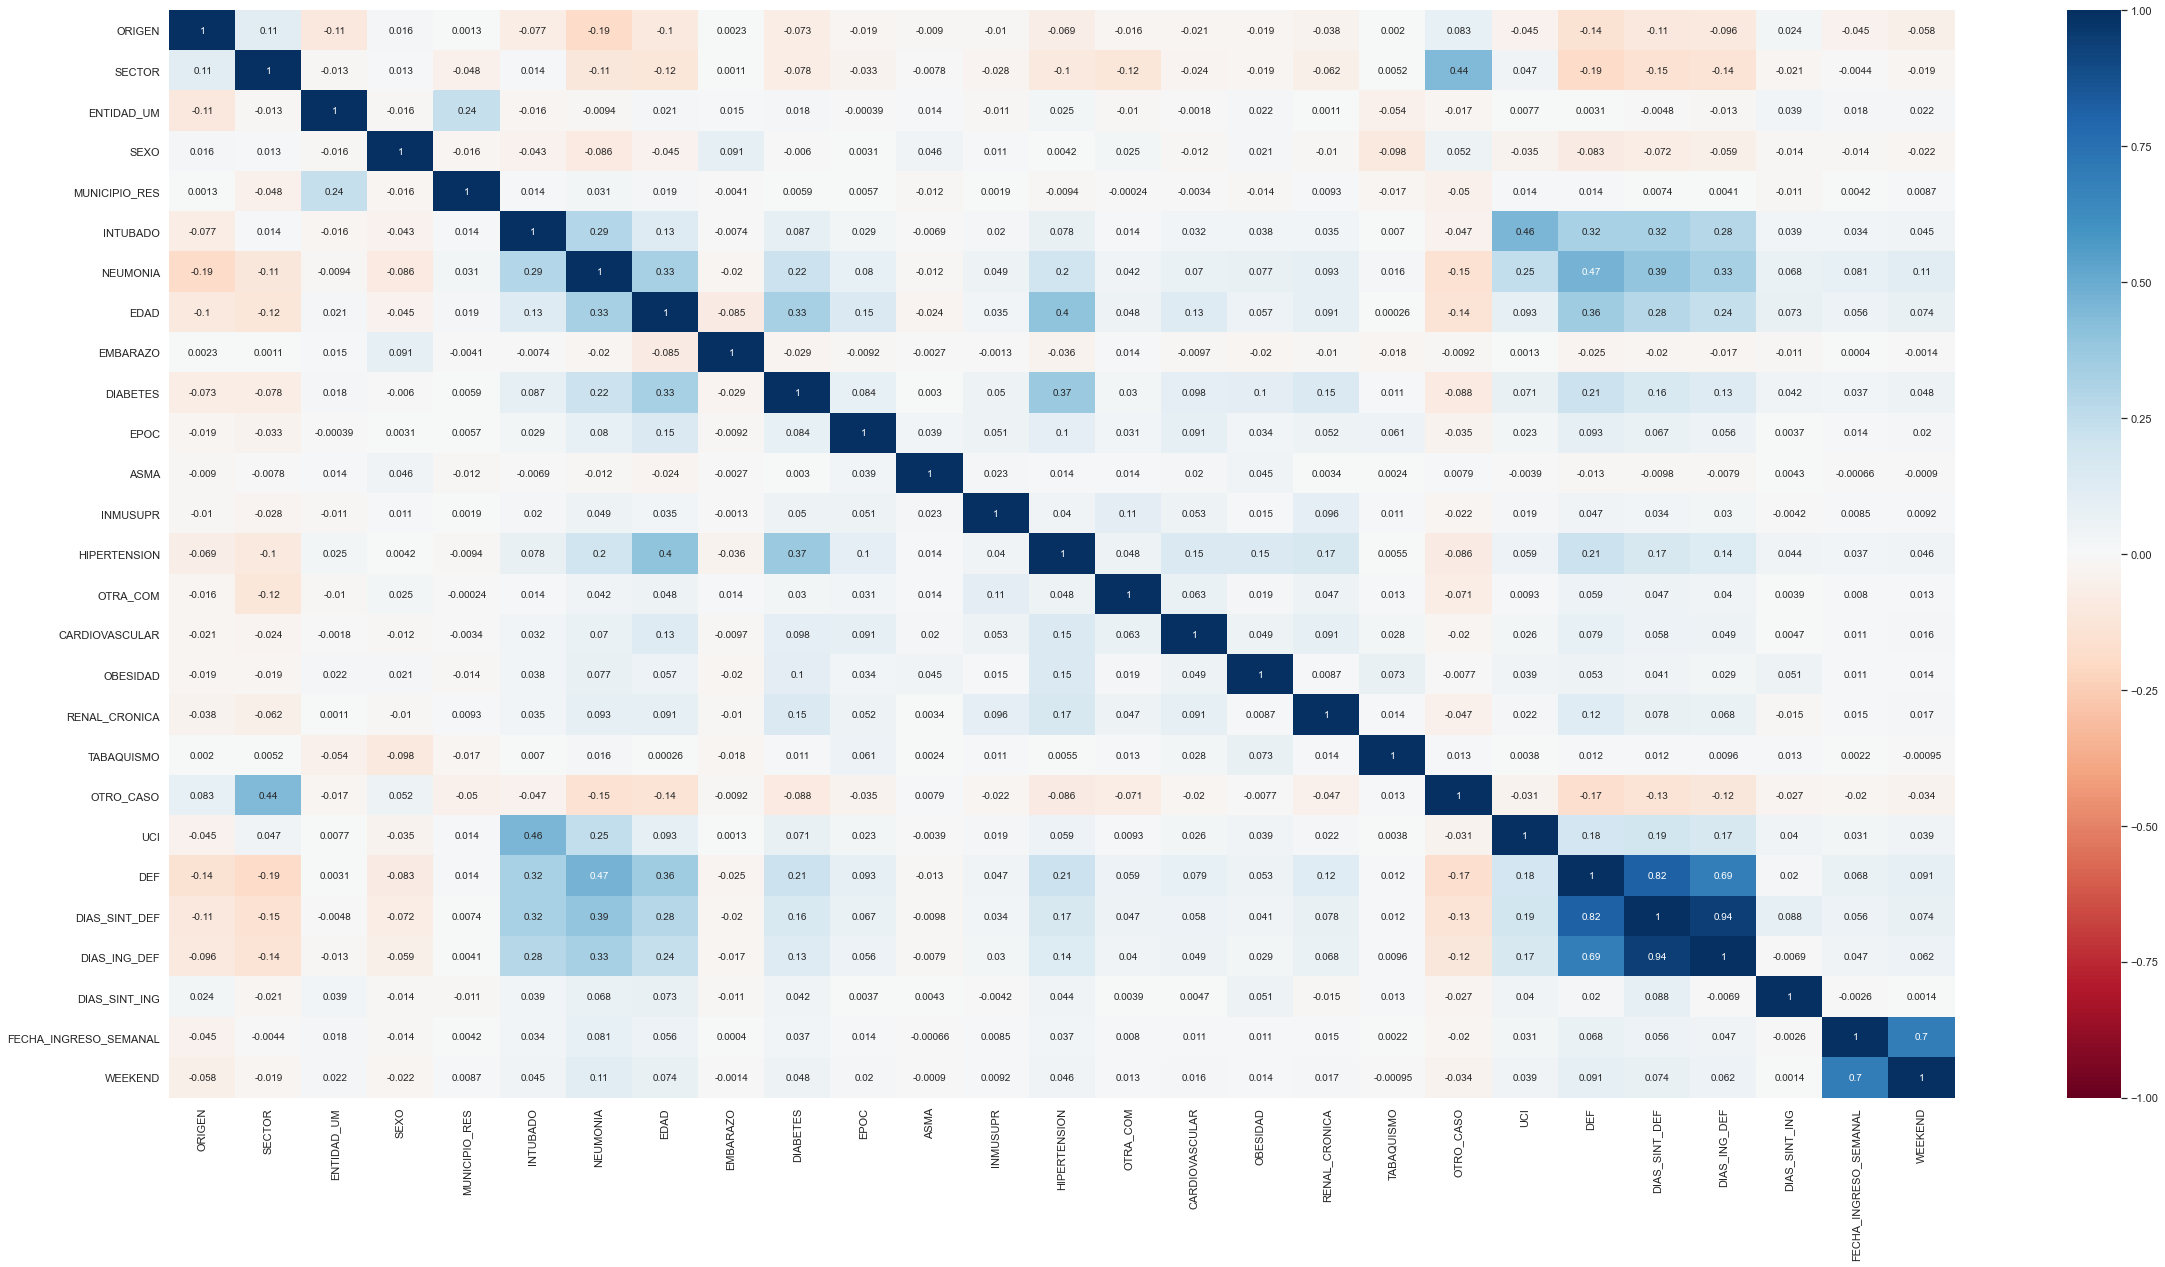

In [21]:
# Blue shows a positive correlation and red a negative. 
correlation = df_positive.corr()
plt.figure(figsize=(40, 20))
sns.heatmap(correlation, annot=True, linewidths=0, vmin=-1, cmap="RdBu")

## Defining baseline model
* Which factor has the biggest impact on predicting death once infected with COVID-19?



### Feature selection
Lets defind feature sets, X:

In [22]:
df_positive.shape

(492522, 34)

In [23]:
df_positive.columns

Index(['FECHA_ACTUALIZACION', 'ID_REGISTRO', 'ORIGEN', 'SECTOR', 'ENTIDAD_UM',
       'SEXO', 'MUNICIPIO_RES', 'TIPO_PACIENTE', 'FECHA_INGRESO',
       'FECHA_SINTOMAS', 'FECHA_DEF', 'INTUBADO', 'NEUMONIA', 'EDAD',
       'EMBARAZO', 'DIABETES', 'EPOC', 'ASMA', 'INMUSUPR', 'HIPERTENSION',
       'OTRA_COM', 'CARDIOVASCULAR', 'OBESIDAD', 'RENAL_CRONICA', 'TABAQUISMO',
       'OTRO_CASO', 'PAIS_ORIGEN', 'UCI', 'DEF', 'DIAS_SINT_DEF',
       'DIAS_ING_DEF', 'DIAS_SINT_ING', 'FECHA_INGRESO_SEMANAL', 'WEEKEND'],
      dtype='object')

## One Hot Encoding

In [114]:
Feature = df_positive[['SEXO','INTUBADO', 'NEUMONIA', 'EDAD',
                      'DIABETES', 'EPOC', 'ASMA', 'INMUSUPR', 'HIPERTENSION',
                      'OTRA_COM', 'CARDIOVASCULAR', 'OBESIDAD', 'RENAL_CRONICA', 'TABAQUISMO',
                      'UCI', 'DIAS_SINT_ING']]
Feature = pd.concat([Feature,pd.get_dummies(df_positive['TIPO_PACIENTE'])], axis=1)
Feature.head()

SEXO  INTUBADO  NEUMONIA  EDAD  DIABETES  EPOC  ASMA  INMUSUPR  \
0     1         0         0    21         0     0     0         0   
1     1         0         0    43         0     0     0         0   
2     1         0         0    26         0     0     0         0   
3     0         0         0    44         1     0     0         0   
4     1         0         0    34         1     0     0         0   

   HIPERTENSION  OTRA_COM  CARDIOVASCULAR  OBESIDAD  RENAL_CRONICA  \
0             0         0               0         0              0   
1             0         0               0         0              0   
2             0         0               0         0              0   
3             0         0               0         0              0   
4             0         0               0         0              0   

   TABAQUISMO  UCI  DIAS_SINT_ING  AMBULATORIO  HOSPITALIZADO  
0           0    0              3            1              0  
1           0    0              2            1              0  
2           0    0              3            1              0  
3           0    0              9            1              0  
4           0    0              7            0              1

In [115]:
#fig = px.scatter_matrix(Feature)
#fig.show()

In [116]:
X = Feature

In [117]:
y = df_positive['DEF']

In [118]:
y.shape

(492522,)

In [130]:
model = RandomForestRegressor()

In [131]:
model.fit(X, y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [135]:
importance = model.feature_importances_

In [136]:
col_name =['SEXO','INTUBADO', 'NEUMONIA', 'EDAD',
                      'DIABETES', 'EPOC', 'ASMA', 'INMUSUPR', 'HIPERTENSION',
                      'OTRA_COM', 'CARDIOVASCULAR', 'OBESIDAD', 'RENAL_CRONICA', 'TABAQUISMO',
                      'UCI', 'DIAS_SINT_ING', 'AMBULATORIO', 'HOSPITALIZADO']

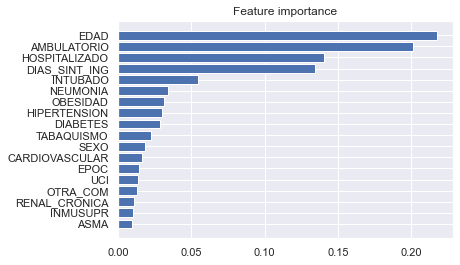

In [137]:
idx = np.argsort(importance)
plt.title('Feature importance')
plt.barh(range(len(idx)), importance[idx], align = 'center')
plt.yticks(range(len(idx)), [col_name[i] for i in idx])
plt.show()


In [238]:
Feature = df_positive[['INTUBADO', 'EDAD',
                       'DIAS_SINT_ING', 'NEUMONIA', 'OBESIDAD','HIPERTENSION','DIABETES', 'TABAQUISMO', 'SEXO']]
Feature = pd.concat([Feature,pd.get_dummies(df_positive['TIPO_PACIENTE'])], axis=1)
Feature.head()

INTUBADO  EDAD  DIAS_SINT_ING  NEUMONIA  OBESIDAD  HIPERTENSION  DIABETES  \
0         0    21              3         0         0             0         0   
1         0    43              2         0         0             0         0   
2         0    26              3         0         0             0         0   
3         0    44              9         0         0             0         1   
4         0    34              7         0         0             0         1   

   TABAQUISMO  SEXO  AMBULATORIO  HOSPITALIZADO  
0           0     1            1              0  
1           0     1            1              0  
2           0     1            1              0  
3           0     0            1              0  
4           0     1            0              1

In [239]:
X = Feature

In [240]:
logit = sm.Logit(y.astype(float), X.astype(float))
result=logit.fit()

Optimization terminated successfully.
         Current function value: 0.201207
         Iterations 8


In [242]:
print(result.summary())

                           Logit Regression Results                           
Dep. Variable:                    DEF   No. Observations:               492522
Model:                          Logit   Df Residuals:                   492511
Method:                           MLE   Df Model:                           10
Date:                Wed, 12 Aug 2020   Pseudo R-squ.:                  0.4176
Time:                        23:49:34   Log-Likelihood:                -99099.
converged:                       True   LL-Null:                   -1.7015e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
INTUBADO          1.5725      0.023     68.490      0.000       1.527       1.617
EDAD              0.0465      0.000    111.004      0.000       0.046       0.047
DIAS_SINT_ING    -0.0286      0.002    -

In [243]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (394017, 11) (394017,)
Test set: (98505, 11) (98505,)


### Normalize Data
Data Standardization give data zero mean and unit variance.

In [244]:
scaler = preprocessing.StandardScaler()
scaler = scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Model for Classification



## LogisticRegression

In [245]:
LR_model = LogisticRegression(C=0.01, solver='lbfgs').fit(X_train,y_train)
LR_model

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [246]:
LR_model.score(X_test, y_test)

0.9064006903202884

In [247]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

              precision    recall  f1-score   support

           0       0.93      0.97      0.95     87771
           1       0.60      0.41      0.49     10734

    accuracy                           0.91     98505
   macro avg       0.77      0.69      0.72     98505
weighted avg       0.89      0.91      0.90     98505

Confusion matrix, without normalization
[[84915  2856]
 [ 6364  4370]]


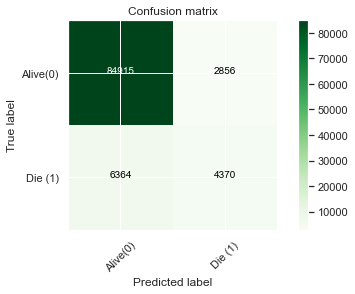

In [248]:
LR_yhat = LR_model.predict(X_test) # Predict class labels for samples in X.
cnf_matrix = confusion_matrix(y_test, LR_yhat, labels=[0,1])
np.set_printoptions(precision=2)

print (classification_report(y_test, LR_yhat))


plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Alive(0)','Die (1)'],normalize= False,  title='Confusion matrix')

In [249]:
LR_yhat = LR_model.predict(X_test) # Predict class labels for samples in X.
LR_yhat_prob = LR_model.predict_proba(X_test) # Probability estimates.
logistic_jaccard = jaccard_similarity_score(y_test, LR_yhat)
logistic_f1 = f1_score(y_test, LR_yhat, average='weighted') 
logistic_log_loss = log_loss(y_test, LR_yhat_prob)
print ("LR Jaccard index: %.2f" % logistic_jaccard)
print ("LR F1-score: %.2f" % logistic_f1)
print ("LR LogLoss: %.2f" % logistic_log_loss)

LR Jaccard index: 0.91
LR F1-score: 0.90
LR LogLoss: 0.20


/Users/erika/Documents/COVID/myenv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:664: FutureWarning:

jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.



## Support Vector Machine 

In [250]:
clf = SGDClassifier(max_iter=1000, tol=1e-3)

In [251]:
clf.fit(X_train, y_train) 

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [252]:
clf.score(X_test, y_test)

0.9025430181209075

In [253]:
SVM_yhat = clf.predict(X_test)

              precision    recall  f1-score   support

           0       0.91      0.99      0.95     87771
           1       0.72      0.17      0.28     10734

    accuracy                           0.90     98505
   macro avg       0.82      0.58      0.61     98505
weighted avg       0.89      0.90      0.87     98505

Confusion matrix, without normalization
[[87075   696]
 [ 8904  1830]]


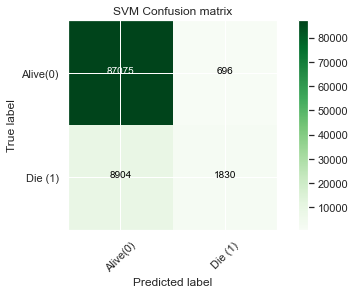

In [254]:
cnf_matrix = confusion_matrix(y_test, SVM_yhat, labels=[0,1])
np.set_printoptions(precision=2)

print (classification_report(y_test, SVM_yhat))


plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Alive(0)','Die (1)'],normalize= False,  title='SVM Confusion matrix')

In [255]:
SVM_jaccard = jaccard_similarity_score(y_test,SVM_yhat)
SVM_f1 = f1_score(y_test,SVM_yhat, average='weighted')
print ("SVM Jaccard index: %.2f" %  SVM_jaccard)
print ("SVM F1-score: %.2f" % SVM_f1)

SVM Jaccard index: 0.90
SVM F1-score: 0.87


/Users/erika/Documents/COVID/myenv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:664: FutureWarning:

jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.



In [256]:
table = [ ["SVM", "%.3f" % SVM_jaccard, "%.3f" % SVM_f1,'NA'],
         ["Logistic Regression", "%.3f" %  logistic_jaccard, "%.3f" % logistic_f1, "%.3f" % logistic_log_loss]]


HTML(tabulate(table, headers= ['Algorithm', 'Jaccard', 'F1-score','LogLoss'], tablefmt='html'))

# Time series

## Forecasting cases of Covid-19 Mexico for the next 90 days. 

In [257]:
df_general_ts = df_general[ df_general['RESULTADO'] == 1]

In [258]:
df_time_pos = df_general.FECHA_SINTOMAS.value_counts().to_frame()
df_time_pos = df_time_pos.reset_index()
df_time_pos.rename(columns={df_time_pos.columns[0]: 'ds', 'FECHA_SINTOMAS': 'y' }, inplace = True)

In [259]:
m = Prophet()
m.fit(df_time_pos)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [260]:
future = m.make_future_dataframe(periods=90)
future.tail()

ds
309 2020-11-05
310 2020-11-06
311 2020-11-07
312 2020-11-08
313 2020-11-09

In [261]:
forecast_cases = m.predict(future)
forecast_cases[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds         yhat   yhat_lower    yhat_upper
309 2020-11-05  8681.995989  5275.291992  12110.544355
310 2020-11-06  9278.523847  5746.246984  13042.586002
311 2020-11-07  8769.890455  5338.032956  12128.519069
312 2020-11-08  8342.686847  4903.854633  12012.757892
313 2020-11-09  9781.726173  6207.546162  13503.074650

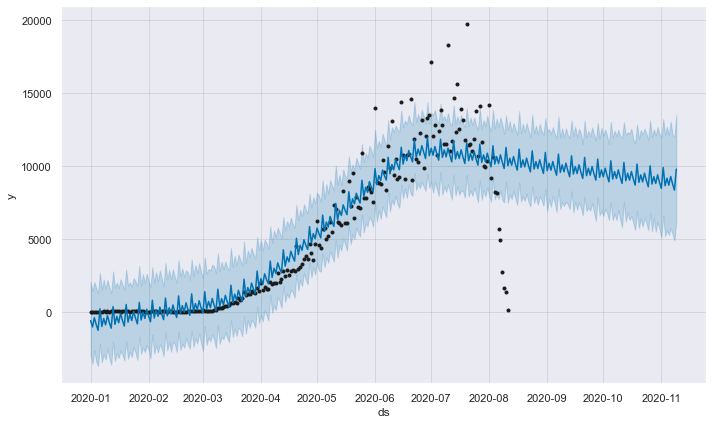

In [262]:
fig1 = m.plot(forecast_cases)

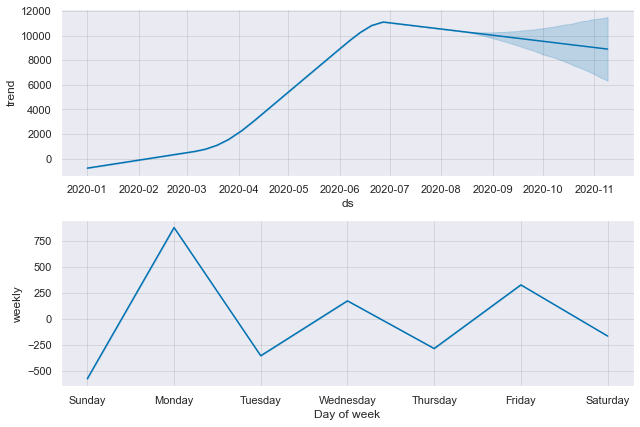

In [263]:
fig2 = m.plot_components(forecast_cases)

In [264]:

py.init_notebook_mode()

fig = plot_plotly(m, forecast_cases)  # This returns a plotly Figure
py.iplot(fig)

## Forecasting death of Covid-19 Mexico for the next 90 days. 

In [265]:
df_general_death = df_general[ df_general['DEF'] == 1]

In [266]:
df_ts_death = df_general_death.FECHA_DEF.value_counts().to_frame()
df_ts_death = df_ts_death.reset_index()
df_ts_death.rename(columns={df_ts_death.columns[0]: 'ds', 'FECHA_DEF': 'y' }, inplace = True)

In [267]:
df_ts_death

ds    y
0   2020-06-16  811
1   2020-07-06  808
2   2020-07-07  800
3   2020-07-13  775
4   2020-06-08  763
..         ...  ...
164 2020-02-13    1
165 2020-01-31    1
166 2020-02-26    1
167 2020-03-09    1
168 2020-01-30    1

[169 rows x 2 columns]

In [268]:
prophet_death = Prophet()
prophet_death.fit(df_ts_death)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [269]:
future_death = prophet_death.make_future_dataframe(periods=90)
future_death.tail()

ds
254 2020-11-05
255 2020-11-06
256 2020-11-07
257 2020-11-08
258 2020-11-09

In [270]:
forecast_death = prophet_death.predict(future_death)
forecast_death[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds        yhat  yhat_lower  yhat_upper
254 2020-11-05  326.470556  120.913854  528.872686
255 2020-11-06  311.528726   92.833621  516.491556
256 2020-11-07  305.773943   78.121550  519.724343
257 2020-11-08  308.498913   99.451628  523.113984
258 2020-11-09  322.054510   99.136374  524.628152

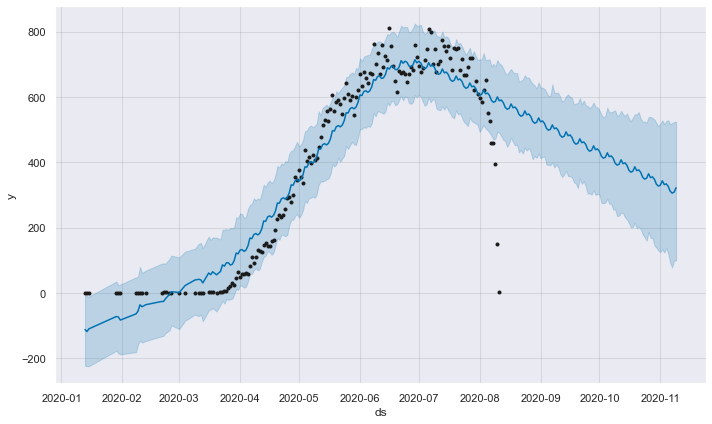

In [271]:
fig1 = prophet_death.plot(forecast_death)

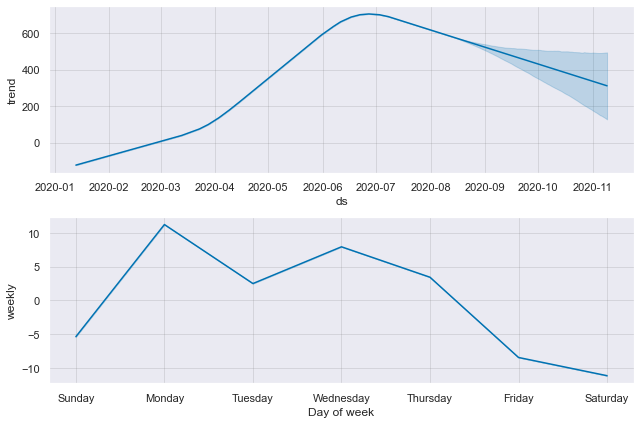

In [272]:
fig2 = prophet_death.plot_components(forecast_death)

In [273]:
py.init_notebook_mode()

fig = plot_plotly(prophet_death, forecast_death)  # This returns a plotly Figure
py.iplot(fig)